### ![Untitled diagram-2025-11-17-052328.png](<attachment:Untitled diagram-2025-11-17-052328.png>)

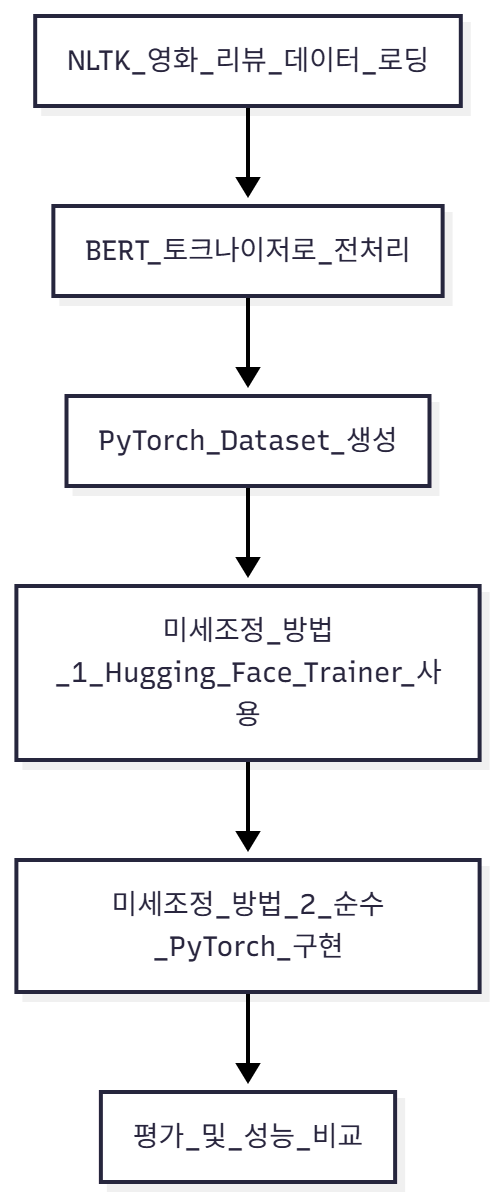

미세조정 전후 비교

In [6]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

test_reviews = [
    "This movie is absolutely amazing! Best film I've ever seen.",
    "Terrible waste of time. Worst movie ever made.",
    "It was okay, nothing special but not bad either.",
    "Brilliant acting and stunning visuals throughout!",
    "Boring and predictable plot. Very disappointed."
]

labels = ["긍정", "부정"]

# 미세 조정전 모델(랜덤 초기화)
BERT_MODEL_NAME = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)
model_before = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL_NAME)
model_before.eval()  #평가모드
with torch.no_grad():
    for i, review in enumerate(test_reviews):
        inputs = tokenizer(review,return_tensors='pt')
        outputs =  model_before(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits,dim=-1)[0]
        pred_label = torch.argmax(probs).item()

        print(f'리뷰 : {i+1} : {review}')
        print(f'예측 : {labels[pred_label]} {probs[pred_label]}')
        print(f'긍정 : {probs[0]} | 부정 : {probs[1]}\n')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


리뷰 : 1 : This movie is absolutely amazing! Best film I've ever seen.
예측 : 부정 0.6057136058807373
긍정 : 0.3942864239215851 | 부정 : 0.6057136058807373

리뷰 : 2 : Terrible waste of time. Worst movie ever made.
예측 : 부정 0.6644940376281738
긍정 : 0.33550596237182617 | 부정 : 0.6644940376281738

리뷰 : 3 : It was okay, nothing special but not bad either.
예측 : 부정 0.5128844380378723
긍정 : 0.4871154725551605 | 부정 : 0.5128844380378723

리뷰 : 4 : Brilliant acting and stunning visuals throughout!
예측 : 부정 0.6150953769683838
긍정 : 0.3849046230316162 | 부정 : 0.6150953769683838

리뷰 : 5 : Boring and predictable plot. Very disappointed.
예측 : 부정 0.6283751130104065
긍정 : 0.3716249167919159 | 부정 : 0.6283751130104065



In [6]:
# 학습 - 미세조정
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
train_texts = [
    ("This is wonderful and fantastic!", 1),  # 긍정
    ("Absolutely terrible and awful!", 0),     # 부정
    ("I love this so much!", 1),
    ("Hated it completely!", 0)
]
BERT_MODEL_NAME = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)
model_after = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL_NAME,num_labels=2)
from transformers import AdamW
optimizer = AdamW(model_after.parameters(), lr=1e-3)
model_after.train()
for epoch in range(5):
    total_loss = 0
    for text,label in train_texts:
        optimizer.zero_grad()
        inputs = tokenizer(text,return_tensors='pt')
        labels = torch.tensor([label])
        outputs = model_after(**inputs,labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    avg_loss = total_loss / len(train_texts)
    print(f'epoch : {epoch+1}  loss : {avg_loss:.4f}')    

c:\Users\playdata2\miniconda3\envs\LLM311\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\playdata2\miniconda3\envs\LLM311\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disabl

epoch : 1  loss : 1.2787
epoch : 2  loss : 1.0154
epoch : 3  loss : 0.7972
epoch : 4  loss : 0.7889
epoch : 5  loss : 0.6323


In [ ]:
print(f'미세조정 후')
with torch.no_grad():
    for i, review in enumerate(test_reviews):
        inputs = tokenizer(review,return_tensors='pt')
        outputs =  model_after(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits,dim=-1)[0]
        pred_label = torch.argmax(probs).item()

        print(f'리뷰 : {i+1} : {review}')
        print(f'예측 : {labels[pred_label]} {probs[pred_label]}')
        print(f'긍정 : {probs[0]} | 부정 : {probs[1]}\n')